## Predicting Yelp Star Ratings 

Notebook showing NLP cabability in scikit-learn to analyze unstructured data by predicting user review star ratings based on review text. A logistic regression model is implemented as well as investigations into models using Naive Bayes, Gradient Boosting, XGBoost and a random forest classifier. In the end logistic regression produces the best results with an accuracy of 93% on test data, and is used for subsequent analysis.

I then investigate using structured data by implementing an ensemble regression model combining K-nearest regressor, linear regressor, decision tree, and ridge techniques. Ratings are predicted using city, location, category, and attributes such as attire and cuisine type. I first look at the performance of this ensemble model by itself, then combine it with the model analyzing review text for a final ensemble model.

Lastly, I perform sentiment analysis using a naive bayes model for calculating key polarizing words and phrases most likely to indicate a negative or positive review.

In [1]:
import seaborn as sns
sns.set()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import gzip
import ujson
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn import base
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from spacy.lang.en.stop_words import STOP_WORDS

2023-09-08 13:27:11.404114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline

In [3]:
%%time
with open('data/yelp_dataset/yelp_academic_dataset_review.json') as f:
    data_full = [json.loads(line) for line in f]

CPU times: user 52.8 s, sys: 11.5 s, total: 1min 4s
Wall time: 1min 7s


In [4]:
data_reduced = data_full#[:1000]

In [5]:
#take a sample of the data
data = data_reduced[len(data_reduced)//30:] 
test_data = data_reduced[:len(data_reduced)//30]

In [6]:
test_data[1]

{'review_id': 'BiTunyQ73aT9WBnpR9DZGw',
 'user_id': 'OyoGAe7OKpv6SyGZT5g77Q',
 'business_id': '7ATYjTIgM3jUlt4UM3IypQ',
 'stars': 5.0,
 'useful': 1,
 'funny': 0,
 'cool': 1,
 'text': "I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.\n\nFor anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).\n\nThere is no way I can write this review without giving Russell, the owner of Body Cycle, a shout out. Russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. He is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. Russell always wears a smile on his face, even when he's kicking yo

In [7]:
stars = [row['stars'] for row in data]
test_stars = [row['stars'] for row in test_data]

In [8]:
print(f'number of rows: {len(data_full)}')

number of rows: 6990280


In [9]:
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame.from_dict(X)
    
to_data_frame = ToDataFrame()

In [10]:
%%time
X_t = to_data_frame.fit_transform(data)

CPU times: user 21.2 s, sys: 32.4 s, total: 53.6 s
Wall time: 1min 11s


In [10]:
X_t.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,XD9brJdWCorqD1IcmG80aw,w2g7cIN23QNkGOob40Szag,8eDkw7CE0NKqMknPIu26fw,5.0,0,0,0,"Great food, perfect for a quick bite. Very nic...",2018-06-13 21:51:19
1,JTRB0MnLGWAQ7tnHs4jdSQ,vqAz3Ny-sknx_KKife4xzA,2er_V-oAd7IbQ5YTY56r7A,4.0,0,0,0,While in Philly we stopped at Bareburger yeste...,2018-01-15 16:42:22
2,simfNhDeg_4SbQCh-UUqlQ,Fp22JL-0E_KRmybLt4fk_g,KDcHC6Es_jv4tloj0NP6gA,5.0,3,0,0,I called this service call in from out of town...,2016-06-16 20:11:15
3,rdvdX0RNjr_iRwf55PBnPQ,_BiFDHusWmQ5AnYq0qHCPw,rVfe1LHo55A2fworkm_jVw,2.0,3,1,0,Blech.. I really wanted to like this place. De...,2016-01-10 22:07:31
4,c_h0lKy4R6ZmXYol2r58Fw,blul5FH-iOt9mWusuWkZtg,uWc9h19N2G8cR7Vo5blL8Q,1.0,1,0,0,"Very very bad service, 1 hour passed by withou...",2018-02-18 22:00:34


<Axes: xlabel='stars', ylabel='Count'>

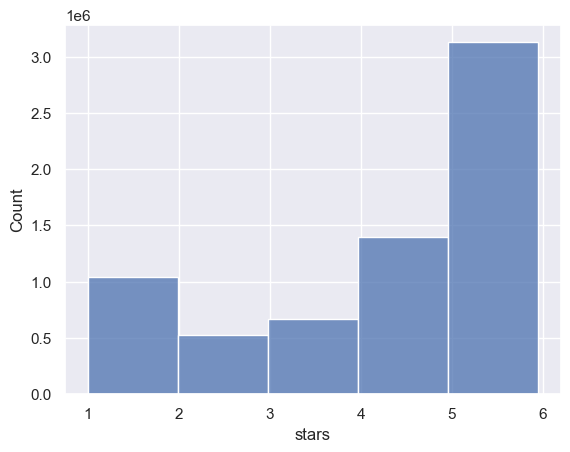

In [15]:
plt.figure()
sns.histplot(data=X_t, x='stars', binwidth=0.99)

Note that in the following word vectorizor, both single word text and bigram text is considered

In [10]:
words_vectorizer = TfidfVectorizer(max_features = 5000, 
                             ngram_range=(1,2), stop_words=list(STOP_WORDS))

In [11]:
text_selector = ColumnTransformer([
    ('text', words_vectorizer, 'text')#,
    #('onehot', OneHotEncoder(handle_unknown='ignore'), ['useful', 'funny', 'cool']) #adding these made the model
                                                                                     #accuracy worse
])

In [12]:
text_model = Pipeline([
    ('data_frame', to_data_frame),
    ('selector', text_selector),
    ('regressor', LogisticRegression(max_iter=1000))
])

In [ ]:
%%time
text_model.fit(data, stars)

CPU times: user 1h 38min 45s, sys: 13min 3s, total: 1h 51min 48s
Wall time: 1h 41min 45s


Pipeline(steps=[('data_frame', ToDataFrame()),
                ('selector',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['get',
                                                                              'that',
                                                                              'very',
                                                                              'above',
                                                                              'hence',
                                                                              'once',
                                                                              'their',
                                                                              'in',
                                                                              'anywhere',
                                                                              'itself',
                                                                              'thru',
                                                                              'latter',
                                                                              'upon',
                                                                              '’re',
                                                                              'each',
                                                                              'make',
                                                                              'being',
                                                                              "'ll",
                                                                              'who',
                                                                              'nine',
                                                                              'top',
                                                                              'ca',
                                                                              'may',
                                                                              'per',
                                                                              'often',
                                                                              'whatever',
                                                                              'anyway',
                                                                              'third',
                                                                              'but',
                                                                              'seemed', ...]),
                                                  'text')])),
                ('regressor', LogisticRegression(max_iter=1000))])

In [ ]:
%%time
#predictions_train = text_model.predict(data)
predictions_test = text_model.predict(test_data)

CPU times: user 24.6 s, sys: 3.3 s, total: 27.9 s
Wall time: 30.9 s


In [ ]:
accuracy_score(test_stars, predictions_test)

0.6582020436978829

In [ ]:
%%time
cv_score = np.mean(cross_val_score(estimator = text_model, X = data, 
                                      y = stars, cv = 3, scoring = 'accuracy'))
cv_score

CPU times: user 3h 25min 38s, sys: 28min 59s, total: 3h 54min 38s
Wall time: 3h 28min 21s


0.6937287257007455

Cross validation provides a similar score to accuracy, giving confidence in the robustness of the result

<Figure size 640x480 with 0 Axes>

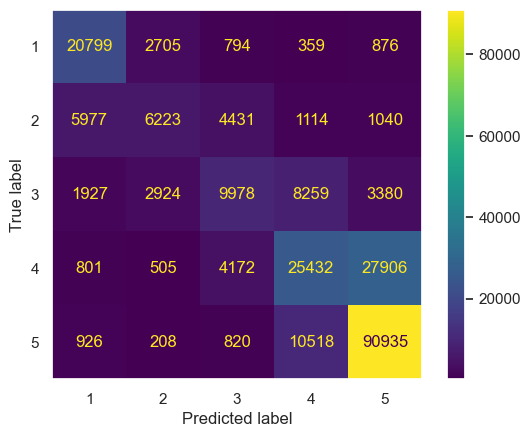

In [ ]:
plt.figure()
conf = confusion_matrix(test_stars, predictions_test) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.grid(False)
plt.show()

It is clear that this model has a clear bias for predicting polarized scores (1 or 5) particularly positive reviews. Lets see if I can improve anything by doing a cross validation grid search optimization

In [ ]:
'''%%time
params={
    'regressor__C':[0.1,1.0,10.0],
    'regressor__penalty':[None,'11','12'],
    'regressor__max_iter':[100,500],
    'regressor__tol':[0.0001, 0.001]
}
grid_pipe = GridSearchCV(text_model,
                         param_grid=params,
                         cv=5,
                         verbose=1)

grid_pipe.fit(data, stars)
# Print the best parameters and the best score
print('Best parameters: ', grid_pipe.best_params_)
print('Best score: ', grid_pipe.best_score_)

y_pred = grid_pipe.predict(test_data)
accuracy = accuracy_score(test_stars, y_pred)
print('Test Accuracy: ', accuracy)'''

Fitting 5 folds for each of 36 candidates, totalling 180 fits


This still didnt improve the model when run on a smaller subset of the data, so I will try using a few different machine learning models to see if the accuracy can be improved

Note: this check was done in a previous run of the notebook, logistic regression shows the best results. Therefore I wont go through the hours it takes to run this again.

In [13]:
'''class denseTransformer():
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray()'''

In [14]:
'''# Create preprocessing and training pipeline for each model
pipeline_nb = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('denseTransformer', denseTransformer()), ('classifier', GaussianNB())])
pipeline_gbc = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('classifier', GradientBoostingClassifier(random_state=42))])
pipeline_xgb = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))])
pipeline_rfc = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('classifier', RandomForestClassifier(random_state=42))])

# List of pipelines and pipeline names
pipelines = [pipeline_nb, pipeline_gbc, pipeline_xgb, pipeline_rfc]
pipeline_names = ['Naive Bayes', 'Gradient Boosting', 'XGBoost', 'Random Forest Classifier']'''

In [19]:
'''%%time
# Convert the data into a DataFrame
X_train_df = to_data_frame.fit_transform(data)
X_test_df = to_data_frame.fit_transform(test_data)
y = np.array(stars) - 1
y_test = np.array(test_stars)
best_accuracy = 0

# Loop to fit each of the pipelines
for pipe, name in zip(pipelines, pipeline_names):
    print('\n', name)
    pipe.fit(X_train_df, y)
    y_pred = pipe.predict(X_test_df)+1
    accuracy = accuracy_score(y_test, y_pred)
    print('Test Accuracy: ', accuracy)
    if accuracy > best_accuracy:
        best_model = pipe
        best_pred = y_pred
        best_accuracy = accuracy'''

"%%time\n# Convert the data into a DataFrame\nX_train_df = to_data_frame.fit_transform(data)\nX_test_df = to_data_frame.fit_transform(test_data)\ny = np.array(stars) - 1\ny_test = np.array(test_stars)\nbest_accuracy = 0\n\n# Loop to fit each of the pipelines\nfor pipe, name in zip(pipelines, pipeline_names):\n    print('\n', name)\n    pipe.fit(X_train_df, y)\n    y_pred = pipe.predict(X_test_df)+1\n    accuracy = accuracy_score(y_test, y_pred)\n    print('Test Accuracy: ', accuracy)\n    if accuracy > best_accuracy:\n        best_model = pipe\n        best_pred = y_pred\n        best_accuracy = accuracy"

In [ ]:
'''plt.figure()
conf = confusion_matrix(test_stars, best_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.grid(False)
plt.show()'''

"plt.figure()\nconf = confusion_matrix(test_stars, best_pred) \ndisp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['1', '2', '3', '4', '5'])\ndisp.plot()\nplt.grid(False)\nplt.show()"

I will now investigate prediction performance using structured data from the business data set. 

In [13]:
%%time
with open('data/yelp_dataset/yelp_academic_dataset_business.json') as f:
    business_data_full = [json.loads(line) for line in f]

CPU times: user 5.4 s, sys: 5.39 s, total: 10.8 s
Wall time: 13 s


In [14]:
#take a sample of the data
business_data_reduced = business_data_full#[:1000]

business_data = business_data_reduced[len(business_data_reduced)//30:] 
business_test_data = business_data_reduced[:len(business_data_reduced)//30]

business_stars = [round(row['stars']) for row in business_data]
business_test_stars = [round(row['stars']) for row in business_test_data]

First I write a regressor class to take in information about the city of the business under review.

In [15]:
#first five cities in data
[d['city'] for d in business_data[:5]]

['Philadelphia', 'Oaks', 'Edmonton', 'Tampa', 'St. Louis']

In [16]:
#class to take into account city of review when predicting rating result
class CityRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_stars = defaultdict(float)
        self.star_sum = defaultdict(int)
        self.count = defaultdict(int)
    
    def fit(self, X, y):
        # Check if X is a DataFrame, necessary due to how later merged pipeline is set up
        is_dataframe = isinstance(X, pd.DataFrame)
        
        # Store the average rating per city in self.avg_stars
        for i, stars in enumerate(y):
            city = X.iloc[i]['city'] if is_dataframe else X[i]['city']
            self.star_sum[city] += stars
            self.count[city] += 1
            
        for city in self.star_sum:
            self.avg_stars[city] = self.star_sum[city] / self.count[city]
            
        return self
    
    def predict(self, X):
        is_dataframe = isinstance(X, pd.DataFrame)
        cities = [X.iloc[i]['city'] if is_dataframe else c['city'] for i, c in enumerate(X)]
        return [self.avg_stars[c] for c in cities]

In [17]:
city_model = CityRegressor()

Next I will implement a K-Nearest Neighbor regressor to take into account the longitude and latitude of the business venue

In [18]:
#first five coordinates
[[d['latitude'], d['longitude']] for d in business_data[:5]]

[[39.941724, -75.152021],
 [40.125841, -75.455434],
 [53.559598, -113.625073],
 [28.0250508, -82.4650148],
 [38.6013121, -90.4295245]]

In [19]:
coord_selector = ColumnTransformer([
    ('coordinates', ToDataFrame(), ['latitude', 'longitude'])
])

In [20]:
lat_long_model = Pipeline([
    ('data frame', to_data_frame),
    ('selector', coord_selector), 
    ('model', KNeighborsRegressor(n_neighbors=69))

])

Now I take in categroy information about the venue and implement Ridge regression. Note due to the merge with the review data set this will always have a resturaunt category, but the category feature has multiple values and other items in the feature may effect review sentiment. 

In [21]:
#first five categories
[d['categories'] for d in business_data[:5]]

['Thrift Stores, Used, Vintage & Consignment, Shopping, Fashion',
 'Fitness & Instruction, Climbing, Gyms, Active Life',
 'Car Dealers, Automotive, Auto Repair, Used Car Dealers',
 'Cafes, Cuban, Restaurants, Nightlife, Bars',
 'Restaurants, Tapas/Small Plates, Wraps, American (New), Burgers']

In [22]:
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        l = list()
        # X will be a pandas series. Return a pandas series of dictionaries
        for x in X:
            k = {}
            try:
                for j in x:
                    k[j] = 1
            except:
                pass
            l.append(k)
        return pd.Series(l)

In [23]:
vector_pipe = Pipeline([
    ('encoder', DictEncoder()),
    ('vectorize', DictVectorizer(sparse=False))

])

In [24]:
categories_selector = ColumnTransformer([
    ('categories', vector_pipe, 'categories')
])

In [25]:
category_model = Pipeline([
    ('data_frame', to_data_frame),
    ('selector', categories_selector),
    ('regressor', Ridge(alpha=6))
])

Now I will work in attribute information. Examples of this might be information about whether the venue accepts credit cards, or what the dress code is. I use a linear model (LinearRegression) to fit the linear part of some data, and use a non-linear model (DecisionTreeRegressor) to fit the residual that the linear model can't fit.

In [26]:
#first 2 attributes
[d['attributes'] for d in business_data[:2]]

[{'BusinessAcceptsCreditCards': 'True',
  'BikeParking': 'True',
  'BusinessAcceptsBitcoin': 'False',
  'RestaurantsPriceRange2': '2',
  'DogsAllowed': 'True',
  'WheelchairAccessible': 'True',
  'BusinessParking': "{u'valet': False, u'garage': False, u'street': True, u'lot': False, u'validated': False}"},
 {'GoodForKids': 'True',
  'BikeParking': 'True',
  'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  'ByAppointmentOnly': 'False',
  'BusinessAcceptsCreditCards': 'True'}]

In [27]:
# Create the transformer to handle the attributes data
class AttributeEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        l = list()
        # X will be a pandas series. Return a pandas series of dictionaries
        for x in X:
            k = {}
            try:
                for j in x:
                    if type(x[j]) == str:
                        k[j+f'_{x[j]}'] = 1
                    
                    elif type(x[j]) == dict:
                        for key in x[j]:  
                            k[j+'_'+key] = x[j][key]
                    else:
                        k[j] = x[j]
            except:
                pass
            l.append(k)
                
        return pd.Series(l)

# Create the linear + non-linear ensemble predictor
class ResidualEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.linear = LinearRegression()
        self.nonlinear = DecisionTreeRegressor(min_samples_split=500)
    def fit(self, X, y):
        self.linear.fit(X,y)
        residual = y - self.linear.predict(X)
        self.nonlinear.fit(X, residual)
        return self
    def predict(self, X):
        linpredict = self.linear.predict(X)
        nonlinear = self.nonlinear.predict(X)
        return linpredict+nonlinear

In [28]:
attribute_pipe = Pipeline([
    ('encoder', AttributeEncoder()),
    ('vectorize', DictVectorizer(sparse=False))

])

In [29]:
attributes_selector = ColumnTransformer([
    ('attribues', attribute_pipe, 'attributes')
])

In [30]:
attribute_model = Pipeline([
    ('data_frame', to_data_frame),
    ('selector', attributes_selector),
    ('regressor', ResidualEstimator())
])

Now I will create an ensemble of the city, lat_long, category and attribute models 

In [31]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        self.model.fit(X,y)
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.model.predict(X))

In [32]:
union = FeatureUnion([
        ('city', ModelTransformer(city_model)),
        ('lat long', ModelTransformer(lat_long_model)),
        ('categoires', ModelTransformer(category_model)),
        ('attributes', ModelTransformer(attribute_model))
    ])

In [33]:
#finally combine all predictions in a linear regression model
feature_model = Pipeline([
    ('features', union),
    ('regressor', LogisticRegression())
])

In [36]:
feature_model.fit(business_data, business_stars)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 ModelTransformer(model=CityRegressor())),
                                                ('lat long',
                                                 ModelTransformer(model=Pipeline(steps=[('data '
                                                                                         'frame',
                                                                                         ToDataFrame()),
                                                                                        ('selector',
                                                                                         ColumnTransformer(transformers=[('coordinates',
                                                                                                                          ToDataFrame(),
                                                                                                                          ['latitude',
                                                                                                                           'longitude'])])),
                                                                                        ('model',
                                                                                         KNeighborsRegressor(n_neighbors=69))]))),
                                                ('categoir...
                                                                                        ('regressor',
                                                                                         Ridge(alpha=6))]))),
                                                ('attributes',
                                                 ModelTransformer(model=Pipeline(steps=[('data_frame',
                                                                                         ToDataFrame()),
                                                                                        ('selector',
                                                                                         ColumnTransformer(transformers=[('attribues',
                                                                                                                          Pipeline(steps=[('encoder',
                                                                                                                                           AttributeEncoder()),
                                                                                                                                          ('vectorize',
                                                                                                                                           DictVectorizer(sparse=False))]),
                                                                                                                          'attributes')])),
                                                                                        ('regressor',
                                                                                         ResidualEstimator())])))])),
                ('regressor', LogisticRegression())])

In [ ]:
business_predictions_test = feature_model.predict(business_test_data)
business_predictions_test = [float(round(item)) for item in business_predictions_test]

In [38]:
accuracy_score(business_test_stars, business_predictions_test)

0.5865096787068449

<Figure size 640x480 with 0 Axes>

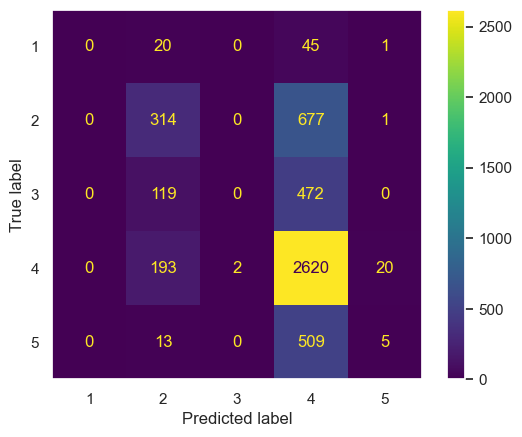

In [39]:
plt.figure()
conf = confusion_matrix(business_test_stars, business_predictions_test) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.grid(False)
plt.show()

You can see this ensemble model performs worse than the NLP model reviewing unstructured text, although it appears less biased. However note that this training set includes multiple categories, not just resturaunts, so it is not a 1:1 comparison

I will now combine the feature ensemble model with the NLP review text model for a final result

In [39]:
#class to merge the business data features with the review text data frame 
class merge_datasets(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X1, X2 = X
        X1 = pd.DataFrame.from_dict(X1)
        X2 = pd.DataFrame.from_dict(X2)
        merge_columns = ['business_id', 'city', 'latitude', 'longitude', 'categories', 'attributes']

        merged_df = X1.merge(X2[merge_columns], on='business_id', how='left')
        columns_to_include = merge_columns + ['text', 'stars']
        return merged_df[columns_to_include].to_dict(orient='records')

merge_data = merge_datasets()


In [40]:
final_union = FeatureUnion([
        ('features', ModelTransformer(feature_model)),
        ('text', ModelTransformer(text_model))
    ])

In [41]:
merged_data_full = merge_data.fit_transform((data_full, business_data_full))

In [42]:
#take a sample of the data
merged_data_reduced = merged_data_full#[:1000]

merged_data = merged_data_reduced[len(merged_data_reduced)//30:] 
merged_test_data = merged_data_reduced[:len(merged_data_reduced)//30]

merged_stars = [round(row['stars']) for row in merged_data]
merged_test_stars = [round(row['stars']) for row in merged_test_data]

In [43]:
merged_text_model = Pipeline([
    ('features', final_union),
    ('regressor', LogisticRegression(max_iter=1000))
])

In [44]:
merged_text_model.fit(merged_data, merged_stars)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('features',
                                                 ModelTransformer(model=Pipeline(steps=[('features',
                                                                                         FeatureUnion(transformer_list=[('city',
                                                                                                                         ModelTransformer(model=CityRegressor())),
                                                                                                                        ('lat '
                                                                                                                         'long',
                                                                                                                         ModelTransformer(model=Pipeline(steps=[('data '
                                                                                                                                                                 'frame',
                                                                                                                                                                 ToDataFrame()),
                                                                                                                                                                ('selector',
                                                                                                                                                                 ColumnTransformer(transformers=[('coordinates',
                                                                                                                                                                                                  ToDataF...
                                                                                                                                                      '‘re',
                                                                                                                                                      '’d',
                                                                                                                                                      'anyone',
                                                                                                                                                      'take',
                                                                                                                                                      'throughout',
                                                                                                                                                      'forty',
                                                                                                                                                      'upon',
                                                                                                                                                      'towards',
                                                                                                                                                      'some',
                                                                                                                                                      'various',
                                                                                                                                                      'while',
                                                                                                                                                      'indeed',
                                                                                                                                                      'herself',
                                                                                     

In [45]:
merged_predictions_test = merged_text_model.predict(merged_test_data)

In [48]:
accuracy_score(merged_test_stars, merged_predictions_test)

0.934295245304


In [49]:
cv_score = np.mean(cross_val_score(estimator = merged_text_model, X = merged_data, 
                                      y = merged_stars, cv = 3, scoring = 'accuracy'))
cv_score

0.9232861565678903


## Key word polarity

Now I will do sentiment analysis to find the most polarizing words, i.e. words most likely to indicate a positive or negative review

Define the polarity of the word as 

$$\textrm{polarity}(w) = \log\left(\frac{Pr(w\ |\ \textrm{positive})}{Pr(w\ |\ \textrm{negative})}\right)$$

I want to do some exploratory analysis of which words correspond to very positive or very negative reviews

In [9]:
stars_full = [row['stars'] for row in data_full]
stars_array = np.asarray(stars_full)
ipolar = np.where((stars_array == 1) | (stars_array == 5))[0]
polar_stars = list(stars_array[ipolar])

In [11]:
polar_data = list(np.asarray(data_full)[ipolar])

In [15]:
X_polar = to_data_frame.fit_transform(polar_data)

In [16]:
polar_selector = ColumnTransformer([
    ('text', to_data_frame, 'text')])

In [17]:
polar_words_selection = polar_selector.fit_transform(X_polar)
polar_words_selection = [p[0] for p in polar_words_selection]

In [18]:
%%time
polar_vectorizer = TfidfVectorizer(max_features = 5000, stop_words=list(STOP_WORDS))
polar_vector = polar_vectorizer.fit_transform(polar_words_selection)

CPU times: user 4min 44s, sys: 48.1 s, total: 5min 32s
Wall time: 6min


In [19]:
#implement naive bayes model
clf = MultinomialNB()

In [20]:
%%time
clf.fit(polar_vector, polar_stars)

CPU times: user 2.17 s, sys: 223 ms, total: 2.39 s
Wall time: 2.5 s


MultinomialNB()

In [21]:
probs = clf.feature_log_prob_
pol = probs[1]-probs[0]
isort = np.argsort(pol)
polar_tokens = polar_vectorizer.get_feature_names_out()

In [22]:
num = 25
positive = np.flip(polar_tokens[isort][-num:])
positive_polarity = np.flip(pol[isort][-num:])
negative = polar_tokens[isort][:num]
negative_polarity = pol[isort][:num]

Lets look at the 25 most polarizing words, i.e. words with the highest polarity score in the 1 and 5 star review texts

<Axes: >

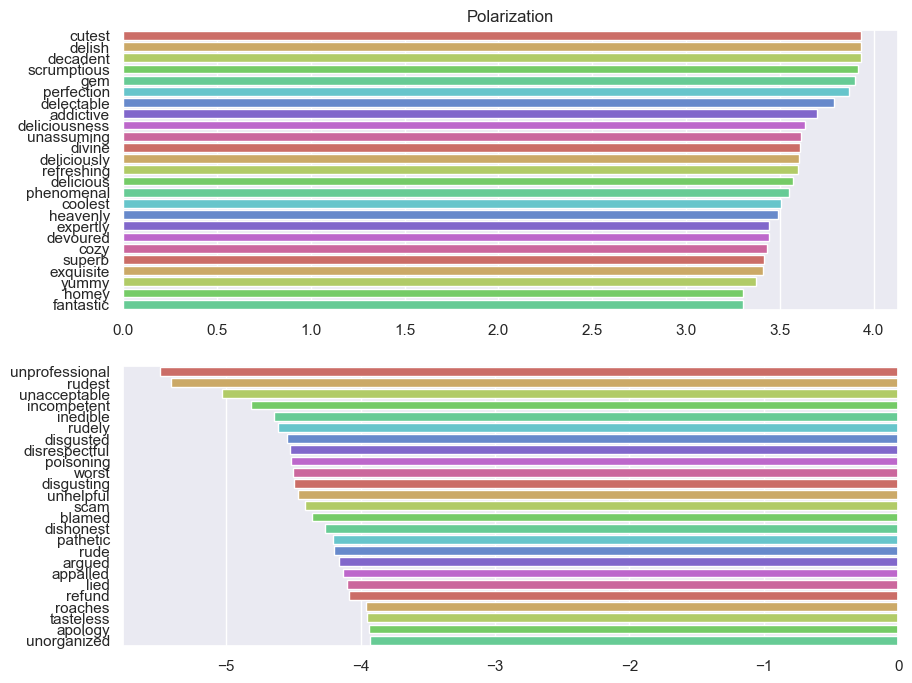

In [23]:
fig, axes = plt.subplots(2, 1, figsize = (10,8))
axes[0].set_title(f'Polarization')
#axes[1].set_title(f'Polarization')
sns.barplot(y=positive, x=positive_polarity, ax=axes[0], palette=sns.color_palette("hls", 10))
sns.barplot(y=negative, x=negative_polarity, ax=axes[1], palette=sns.color_palette("hls", 10))

We can also conduct the same analysis on bigrams, inidicating the most polarizing phrases

In [24]:
%%time
polar_bigram_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range=(1,2), stop_words=list(STOP_WORDS))
polar_bigram_vector = polar_bigram_vectorizer.fit_transform(polar_words_selection)

CPU times: user 14min, sys: 1min 34s, total: 15min 35s
Wall time: 16min 54s


In [25]:
%%time
clf_bigram = MultinomialNB()
clf_bigram.fit(polar_bigram_vector, polar_stars)

CPU times: user 2.16 s, sys: 439 ms, total: 2.6 s
Wall time: 3.04 s


MultinomialNB()

In [28]:
probs_bigram = clf_bigram.feature_log_prob_
pol_bigram = probs_bigram[1]-probs_bigram[0]
isort_bigram = np.argsort(pol_bigram)
polar_bigram_tokens = polar_bigram_vectorizer.get_feature_names_out()

In [29]:
num = 25
positive_bigram = np.flip(polar_bigram_tokens[isort_bigram][-num:])
positive_bigram_polarity = np.flip(pol_bigram[isort_bigram][-num:])
negative_bigram = polar_bigram_tokens[isort_bigram][:num]
negative_bigram_polarity = pol_bigram[isort_bigram][:num]

<Axes: >

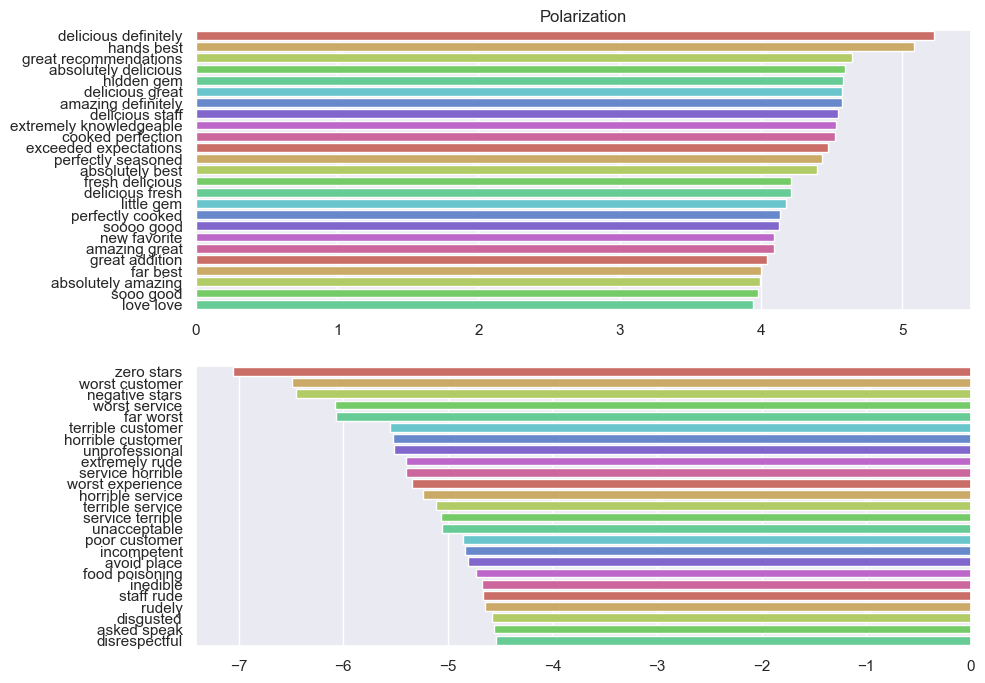

In [30]:
fig, axes = plt.subplots(2, 1, figsize = (10,8))
axes[0].set_title(f'Polarization')
#axes[1].set_title(f'Polarization')
sns.barplot(y=positive_bigram, x=positive_bigram_polarity, ax=axes[0], palette=sns.color_palette("hls", 10))
sns.barplot(y=negative_bigram, x=negative_bigram_polarity, ax=axes[1], palette=sns.color_palette("hls", 10))

## Conclusions

By itself, logistic regression on unstructured text data performs better than using structured business data features in an ensemble model including of a combination of K-nearest regressor, linear regressor, decision tree, and ridge techniques. However at roughly 70% accuracy there is still a clear bias towards polarized predictions as shown in the confusion matrix for that prediction. 

When combining the ensemble feature model with the logistic regression on unstructured text data (NLP technique) the best result is obtained with an accuracy on test data of 93%